In [1]:
import pandas as pd
import plotnine as p9
import numpy as np
from util import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
scale_x_hours_as_dow = p9.scale_x_continuous(breaks=range(0,24*8, 24), minor_breaks=1, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', ''])

In [3]:
df = pd.read_parquet("../data/preprocessed.parquet")

# These columns are pointless to plot
df.drop(labels=['description', 'service_id', 'half_desc'], axis=1, inplace=True)
df.dtypes

services               object
severity               object
range                  object
users                  object
cause                  object
duration               object
affected               object
service_name           object
location               object
status                float64
vendor                 object
first_notification      Int64
last_notification       Int64
monitor                object
org_type               object
duration_min          float64
hour_of_week            Int32
cause_broader          object
dtype: object

Not provided:
- range: 7 events, 2.08\%
- services: 8 events, 2.37\%
- cause: 182 events, 54.01\%


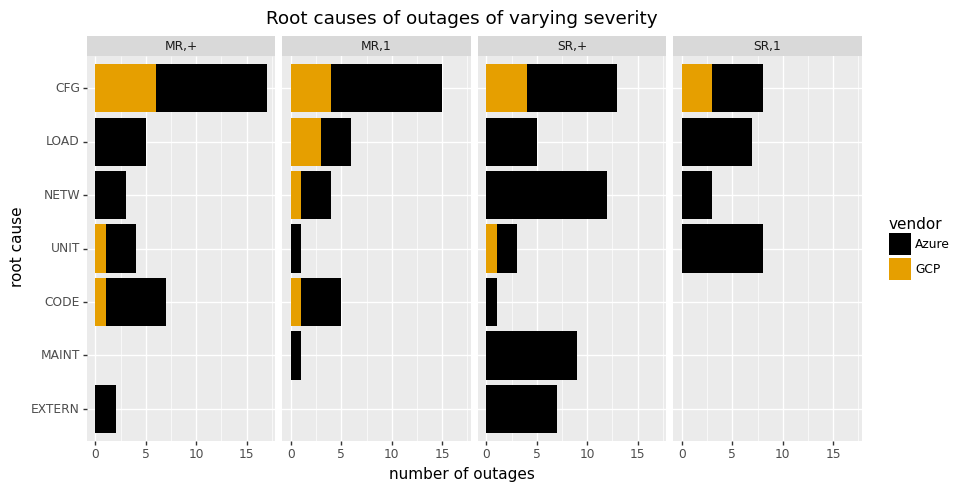

<ggplot: (307336341)>


In [4]:
# Removing single availability zone because only applies to AWS
# Removing AWS because not much data
subdf = df[df.vendor != 'AWS'][['range', 'services', 'vendor', 'cause', 'cause_broader']]

filt = subdf[filter_notprovided(subdf.cause) & filter_notprovided(subdf.range) & filter_notprovided(subdf.services)]

plotdf = pd.DataFrame({'range_services': filt[['range', 'services']].applymap(shorten).agg(','.join, axis=1),
                       'cause_broader': filt.cause_broader.map(shorten),
                       'vendor': filt.vendor})

cause_categs = plotdf.cause_broader.value_counts(ascending=True).index.tolist()

export_graph("root-causes-by-severity", subdf, ['range', 'services', 'cause'],
             (p9.ggplot(plotdf)
              + p9.aes(x='cause_broader', fill='vendor') 
              + p9.geom_bar()
              + p9.scale_x_discrete(limits=cause_categs)
              + p9.coord_flip()
              + p9.theme(figure_size=(10,5))
              + disc_fillpalette
              + p9.facet_grid("~ range_services")
              + p9.labs(y="number of outages", x="root cause")
              + p9.ggtitle("Root causes of outages of varying severity")))

Not provided:
- range: 7 events, 1.46\%
- services: 8 events, 1.66\%
- affected: 66 events, 13.72\%


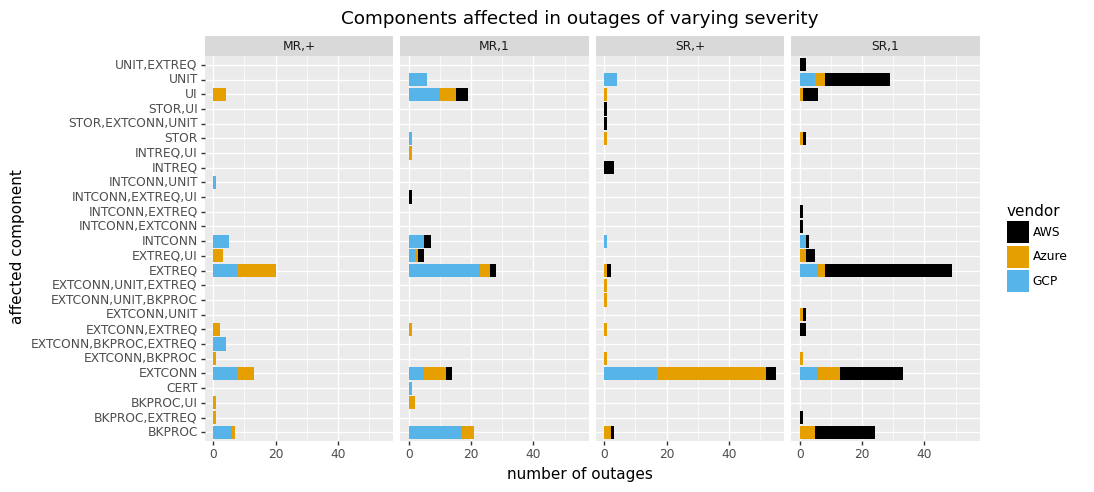

<ggplot: (310021361)>


In [5]:
# Removing single availability zone because only applies to AWS
subdf = df[['range', 'services', 'vendor', 'affected']]

filt = subdf[filter_notprovided(subdf.affected) & filter_notprovided(subdf.range) & filter_notprovided(subdf.services)]

plotdf = pd.DataFrame({'range_services': filt[['range', 'services']].applymap(shorten).agg(','.join, axis=1),
                       'affected': filt.affected.map(lambda x: ','.join(map(shorten, x))),
                       'vendor': filt.vendor})

export_graph("components-by-severity", subdf, ['range', 'services', 'affected'],
             (p9.ggplot(plotdf)
              + p9.aes(x='affected', fill='vendor') 
              + p9.geom_bar()
              + p9.coord_flip()
              + p9.theme(figure_size=(10,5))
              + disc_fillpalette
              + p9.facet_grid("~ range_services")
              + p9.labs(y="number of outages", x="affected component")
              + p9.ggtitle("Components affected in outages of varying severity")))

Not provided:
- hours: 0 events, 0.0\%


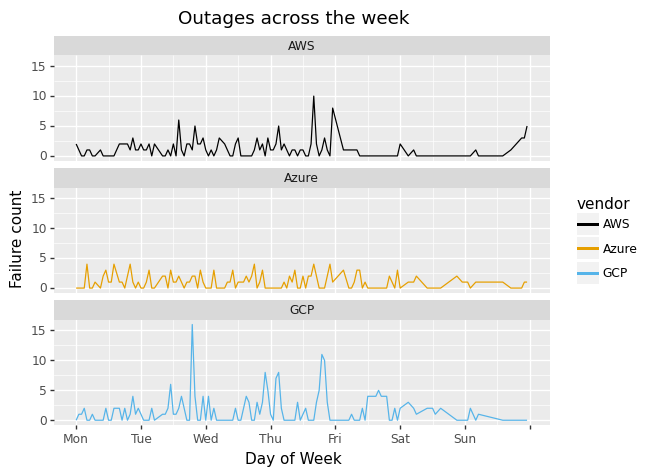

<ggplot: (310725225)>


In [6]:
azure_hours = df[df.vendor == "Azure"].hour_of_week.value_counts()
aws_hours = df[df.vendor == "AWS"].hour_of_week.value_counts()
gcp_hours = df[df.vendor == "GCP"].hour_of_week.value_counts()

plotdf = (pd.DataFrame({'Azure': azure_hours,
                       'GCP': gcp_hours,
                       'AWS': aws_hours})
          .applymap(lambda x: 0 if pd.isna(x) else x)
          .reset_index().rename(columns={"index": "hours"}))

export_graph("outages-across-week", plotdf, ['hours'],
             (p9.ggplot(plotdf.melt(id_vars='hours', var_name='vendor', value_name='outages_count'))
              + p9.aes(x='hours', y='outages_count', color='vendor')
              + p9.geom_line()
              + scale_x_hours_as_dow
              + p9.labs(x='Day of Week', y='Failure count')
              + p9.facet_wrap('vendor', nrow=3, ncol=1)
              + disc_colorpalette
              + p9.scale_color_manual(values=colorblindPalette)
              + p9.ggtitle("Outages across the week")))

Not provided:
- affected: 66 events, 13.72\%
- hour_of_week: 0 events, 0.0\%


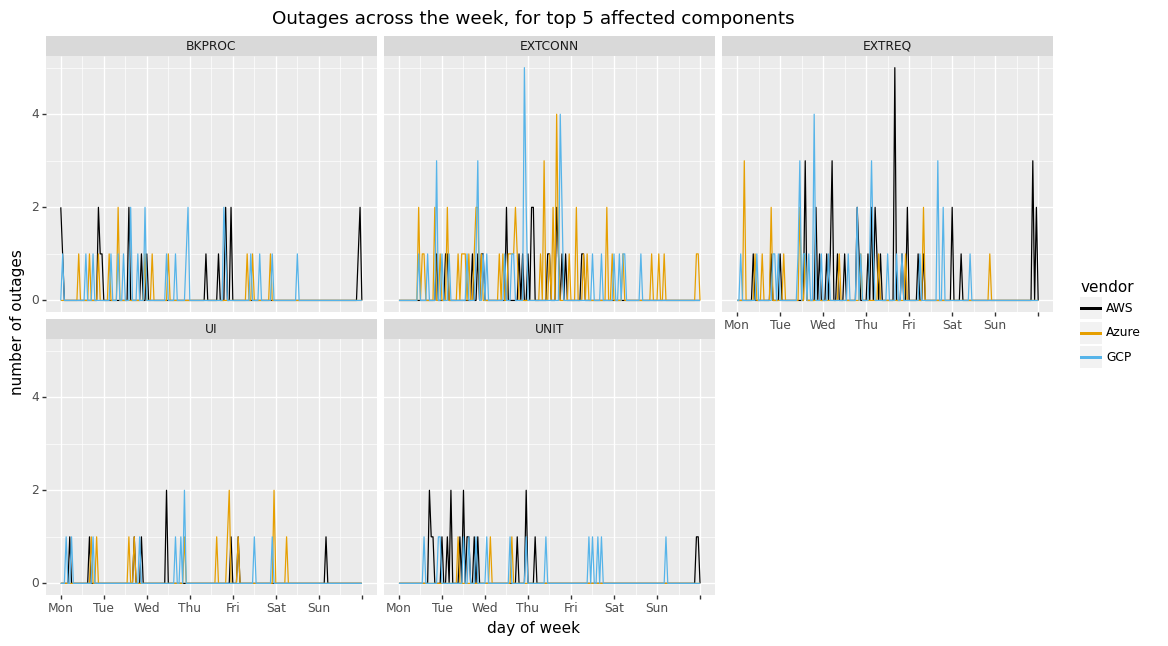

<ggplot: (311263937)>


In [7]:
filt = df[filter_notprovided(df.affected) & df.hour_of_week.notna()]

plotdf = pd.DataFrame({'vendor': filt.vendor,
                       'affected': filt.affected.map(lambda x: ','.join(map(shorten, x))),
                       'hour_of_week': filt.hour_of_week})
top_5_affected = plotdf.affected.value_counts()[0:5].index

plotdf = (plotdf[plotdf.affected.isin(top_5_affected)]
          .melt(id_vars=['vendor', 'affected'], value_name='hour_of_week')
          .drop('variable', axis='columns')
          .groupby(['vendor', 'affected'])
          .hour_of_week.value_counts().reset_index(name='num_outages'))

for vd in set(plotdf.vendor.values):
    for af in set(plotdf[plotdf.vendor == vd].affected.values):
        for i in range(24*7+1):
            if len(plotdf[(plotdf.vendor == vd) & (plotdf.affected == af) & (plotdf.hour_of_week == i)]) == 0:
                plotdf = plotdf.append({'vendor': vd, 'affected': af, 'hour_of_week': i, 'num_outages': 0}, ignore_index=True)

export_graph("components-across-week", df, ['affected', 'hour_of_week'],
             (p9.ggplot(plotdf)
              + p9.aes(x='hour_of_week', y='num_outages', color='vendor')
              + p9.geom_line()
              + p9.facet_wrap('~ affected')
              + p9.scale_y_continuous(breaks=lambda x: range(0, int(np.ceil(x[1])), 2))
              + scale_x_hours_as_dow
              + p9.labs(x='day of week', y='number of outages')
              + p9.theme(figure_size=(13,7))
              + disc_colorpalette
              + p9.ggtitle("Outages across the week, for top 5 affected components")))

Not provided:
- cause: 323 events, 67.15\%
- hour_of_week: 0 events, 0.0\%


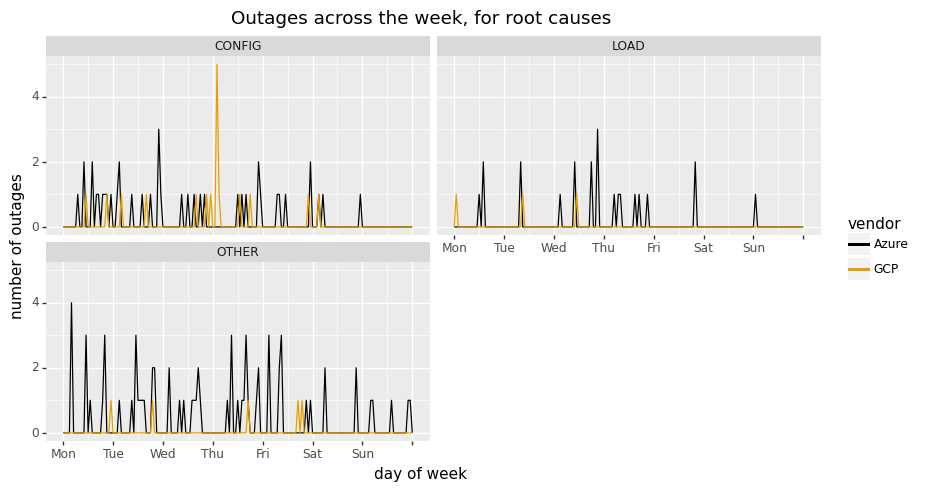

<ggplot: (312098809)>


In [8]:
# Remove AWS because lack of data
filt = df[filter_notprovided(df.cause) & df.hour_of_week.notna() & (df.vendor != 'AWS')]

def regroup_causes(cell):
    cause = shorten(cell)
    if cause == 'CFG':
        return 'CONFIG'
    elif cause == 'LOAD':
        return cause
    else:
        return 'OTHER'
    
plotdf = pd.DataFrame({'vendor': filt.vendor,
                       'cause': filt.cause_broader.map(regroup_causes),
                       'hour_of_week': filt.hour_of_week})

plotdf = (plotdf
          .melt(id_vars=['vendor', 'cause'], value_name='hour_of_week')
          .drop('variable', axis='columns')
          .groupby(['vendor', 'cause'])
          .hour_of_week.value_counts().reset_index(name='num_outages'))

for vd in set(plotdf.vendor.values):
    for cuz in set(plotdf[plotdf.vendor == vd].cause.values):
        for i in range(24*7+1):
            if len(plotdf[(plotdf.vendor == vd) & (plotdf.cause == cuz) & (plotdf.hour_of_week == i)]) == 0:
                plotdf = plotdf.append({'vendor': vd, 'cause': cuz, 'hour_of_week': i, 'num_outages': 0}, ignore_index=True)

export_graph("causes-across-week", df, ['cause', 'hour_of_week'],
             (p9.ggplot(plotdf)
              + p9.aes(x='hour_of_week', y='num_outages', color='vendor')
              + p9.geom_line()
              + p9.facet_wrap('~ cause', nrow=2, ncol=2)
              + p9.scale_y_continuous(breaks=lambda x: range(0, int(np.ceil(x[1])), 2))
              + scale_x_hours_as_dow
              + p9.labs(x='day of week', y='number of outages')
              + p9.theme(figure_size=(10,5))
              + disc_colorpalette
              + p9.ggtitle("Outages across the week, for root causes")))

Not provided:
- cause: 323 events, 67.15\%
- duration_min: 0 events, 0.0\%


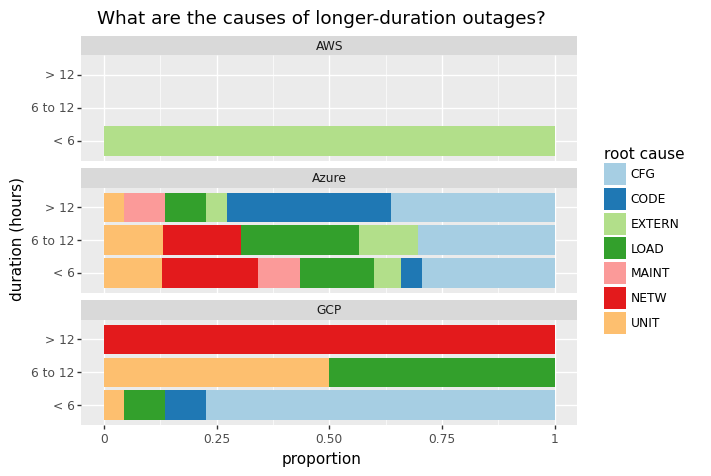

<ggplot: (310725073)>


In [24]:
filtered = df[filter_notprovided(df.cause) & (df.duration_min >= 0)]

def group_duration(x):
    if x/(60.0) < 6:
        return '< 6'
    elif 6 <= x/(60.0) <= 12:
        return '6 to 12'
    else:
        return '> 12'
        
plotdf = (pd.DataFrame({'cause': filtered.cause_broader.map(shorten),
                        'duration_min': filtered.duration_min,
                        'duration_comp': filtered.duration_min.map(group_duration),
                        'vendor': filtered.vendor}))

normdf = plotdf.groupby(['vendor', 'duration_comp']).cause.value_counts(normalize=True).reset_index(name="proportion")

with open("../report/src/numbers/components-vs-duration-n-wrong-times.tex", "w") as f:
    f.write("%d" % len(df[df.duration_min < 0]))

export_graph("causes-vs-duration-hr-ranges", df, ['cause', 'duration_min'],
            (p9.ggplot(normdf)
             + p9.aes(x='duration_comp', y='proportion', fill='cause')
             + p9.facet_wrap('~ vendor', ncol=1)
             + p9.geom_col()
             + disc_fillpalette_larger
             + p9.labs(y="proportion", x="duration (hours)", fill="root cause")
             + p9.scale_x_discrete(limits=['< 6', '6 to 12', '> 12'])
             + p9.coord_flip()
             + p9.ggtitle("What are the causes of longer-duration outages?")))

Not provided:
- users: 1 events, 0.21\%
- range: 7 events, 1.46\%


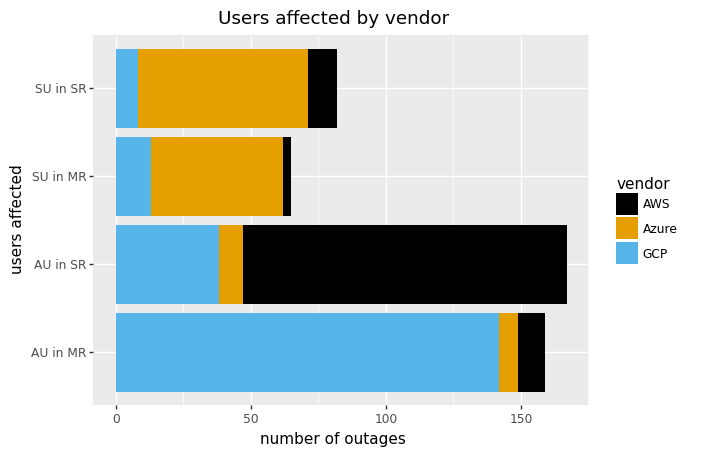

<ggplot: (309919897)>


In [10]:
filt = df[filter_notprovided(df.users) & filter_notprovided(df.range)]
plotdf = pd.DataFrame({'users_range': filt.users.map(shorten)+' in '+filt.range.map(shorten),
                       'vendor': filt.vendor})
export_graph("users-affected-by-vendor", df, ['users', 'range'],
             (p9.ggplot(plotdf)
              + p9.aes(x='users_range', fill='vendor')
              + p9.geom_bar()
              + p9.labs(x='users affected', y='number of outages')
              + p9.coord_flip()
              + disc_fillpalette
              + p9.ggtitle("Users affected by vendor")))

Not provided:
- users: 1 events, 0.21\%
- range: 7 events, 1.46\%
- severity: 59 events, 12.27\%
- duration: 57 events, 11.85\%


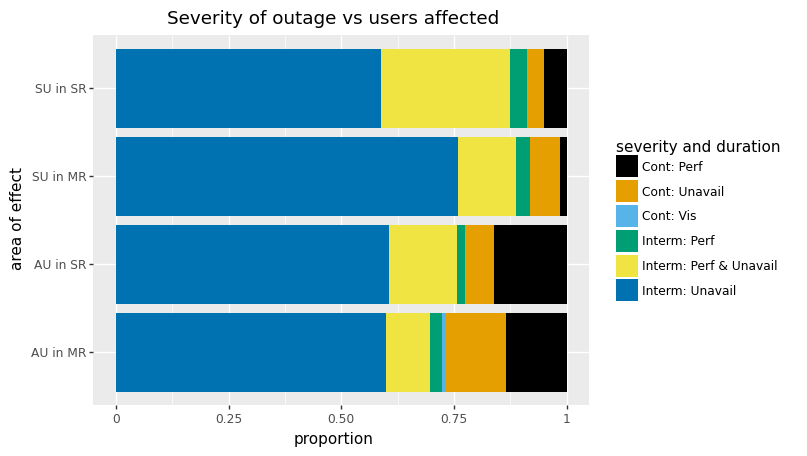

<ggplot: (310236701)>


In [23]:
filt = df[filter_notprovided(df.users) & filter_notprovided(df.range) & filter_notprovided(df.severity) & filter_notprovided(df.duration)]
plotdf = (pd.DataFrame({'area of effect': filt.users.map(shorten)+' in '+filt.range.map(shorten),
                       'severity and duration': (filt.duration.map(shorten)
                                                 +': '
                                                 +filt.severity.map(lambda x: ' & '.join(map(shorten, x))))})
          .groupby(['area of effect'])
          ['severity and duration'].value_counts(normalize=True)
          .reset_index(name='proportion'))

export_graph("severity-vs-users-affected", df, ['users', 'range', 'severity', 'duration'],
             (p9.ggplot(plotdf)
              + p9.ggtitle("Severity of outage vs users affected")
              + p9.aes(x='area of effect', y='proportion', fill='severity and duration')
              + disc_fillpalette
              + p9.coord_flip()
              + p9.geom_col()))

Not provided:
- cause: 323 events, 67.15\%
- range: 7 events, 1.46\%
- users: 1 events, 0.21\%


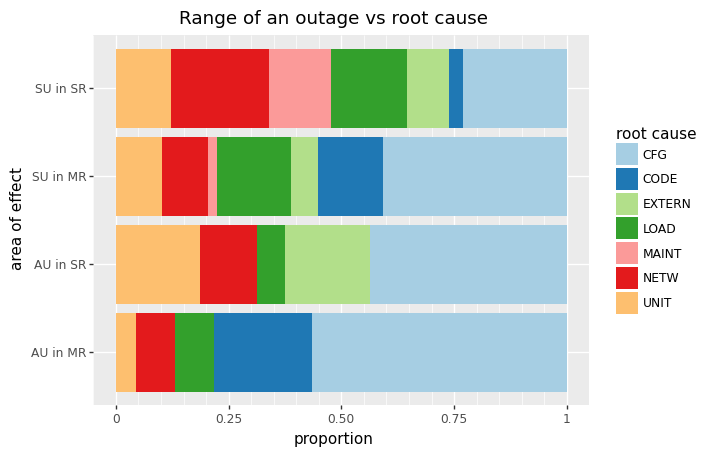

<ggplot: (311775657)>


In [22]:
filt = df[filter_notprovided(df.cause) & filter_notprovided(df.range) & filter_notprovided(df.users)]
plotdf = (pd.DataFrame({'cause': filt.cause_broader.map(shorten), 
                       'range_users': filt.users.map(shorten)+' in '+filt.range.map(shorten)})
          .groupby('range_users')
          .cause.value_counts(normalize=True)
          .reset_index(name='proportion'))

export_graph("range-users-vs-root-cause", df, ['cause', 'range', 'users'],
             (p9.ggplot(plotdf)
              + p9.aes(x='range_users', y='proportion',  fill='cause')
              + p9.geom_col()
              + p9.scale_fill_brewer(type='qual', palette="Paired") # the colorblind-friendly palette is too small here
              + p9.scale_y_continuous(minor_breaks=4)
              + p9.coord_flip()
              + p9.labs(x='area of effect', fill='root cause')
              + p9.ggtitle("Range of an outage vs root cause")))

In [13]:
filt = df[filter_notprovided(df.severity) & filter_notprovided(df.range) & filter_notprovided(df.users) & filter_notprovided(df.duration)
          & filter_notprovided(df.affected) & filter_notprovided(df.cause)]
corrdf = pd.DataFrame({'severity': filt.severity.map(lambda x: ','.join(map(shorten, x))),
              'range': filt.range.map(shorten),
              'users': filt.users.map(shorten),
              'duration': filt.duration.map(shorten),
              'affected': filt.affected.map(lambda x: ','.join(map(shorten, x))),
              'cause': filt.cause.map(shorten)})

Not provided:
- severity: 59 events, 12.27\%
- range: 7 events, 1.46\%
- users: 1 events, 0.21\%
- duration: 57 events, 11.85\%
- affected: 66 events, 13.72\%
- cause: 323 events, 67.15\%


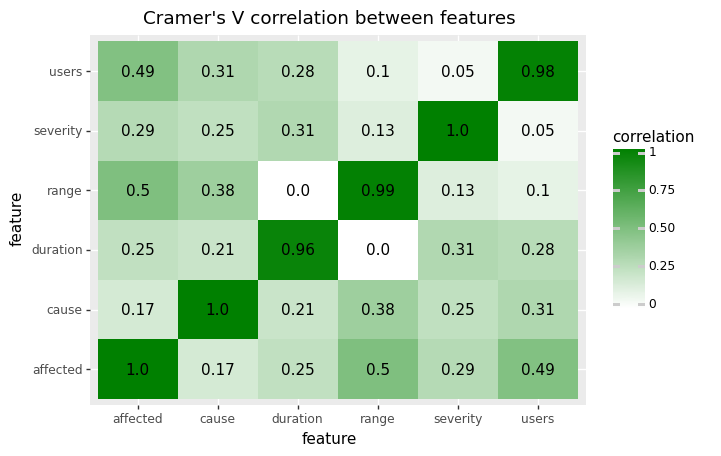

<ggplot: (310673609)>


In [14]:
def cramers_v(x, y):
    import scipy.stats as ss
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def compute_cramers_v_matrix(df, index, columns):
    cramersv = pd.DataFrame(index=index, columns=columns)
    for i in range(0, len(columns)):
        for j in range(0,len(columns)):
            v = cramers_v(df[columns[i]],df[columns[j]])
            cramersv.loc[columns[i],columns[j]] = v
            cramersv.loc[columns[j],columns[i]] = v
    cramersv.fillna(value=np.nan,inplace=True)
    return cramersv

export_graph("cramers-v", df, ['severity', 'range', 'users', 'duration', 'affected', 'cause'],
             (p9.ggplot(corrdf.pipe(compute_cramers_v_matrix, index=corrdf.columns, columns=corrdf.columns)
                        .stack()
                        .reset_index(name='correlation')
                        .rename(columns={'level_0': 'x', 'level_1': 'y'}))
              + p9.aes(x='x', y='y', fill='correlation', label='round(correlation, 2)')
              + p9.scale_fill_gradient(low='white', high='green')
              + p9.geom_tile()
              + p9.geom_text()
              + p9.labs(x='feature', y='feature')
              + p9.ggtitle("Cramer's V correlation between features")))

Not provided:
- severity: 59 events, 12.27\%
- range: 7 events, 1.46\%
- users: 1 events, 0.21\%
- duration: 57 events, 11.85\%
- affected: 66 events, 13.72\%
- cause: 323 events, 67.15\%


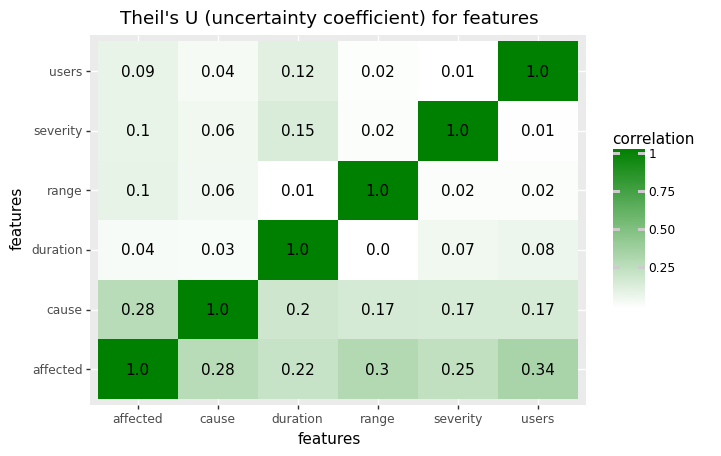

<ggplot: (310674685)>


In [15]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://datascience.stackexchange.com/questions/26444/is-there-an-asymmetric-version-of-nominal-correlation
# https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival
def theils_u(x,y):
    from collections import Counter
    import scipy.stats as ss
    def conditional_entropy(x,y):
        # entropy of x given y
        import math
        y_counter = Counter(y)
        xy_counter = Counter(list(zip(x,y)))
        total_occurrences = sum(y_counter.values())
        entropy = 0
        for xy in xy_counter.keys():
            p_xy = xy_counter[xy] / total_occurrences
            p_y = y_counter[xy[1]] / total_occurrences
            entropy += p_xy * math.log(p_y/p_xy)
        return entropy
    
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def compute_theils_u_matrix(df, index, columns):
    theilsu = pd.DataFrame(index=index, columns=columns)
    for i in range(0, len(columns)):
        for j in range(0,len(columns)):
            u = theils_u(df[columns[i]].tolist(),df[columns[j]].tolist())
            theilsu.loc[columns[i],columns[j]] = u
    theilsu.fillna(value=np.nan,inplace=True)
    return theilsu

export_graph("theils-u", df, ['severity', 'range', 'users', 'duration', 'affected', 'cause'],
             (p9.ggplot(corrdf.pipe(compute_theils_u_matrix, corrdf.columns, corrdf.columns)
                        .stack()
                        .reset_index(name='correlation')
                        .rename(columns={'level_0': 'x', 'level_1': 'y'}))
              + p9.aes(x='x', y='y', fill='correlation', label='round(correlation, 2)')
              + p9.geom_tile()
              + p9.geom_text()
              + p9.scale_fill_gradient(low='white', high='green')
              + p9.labs(x='features', y='features')
              + p9.ggtitle("Theil's U (uncertainty coefficient) for features")))